In [1]:
import torch
import torch.optim as optim
import torch.autograd as autograd
import autograd.numpy as np
from tqdm import tqdm, trange
from kernel import RBF


from svgd import SVGD
import argparse

from utils import plot_particles
import torch.distributions as D
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [2]:
parser = argparse.ArgumentParser(description='Running xshaped experiment.')

parser.add_argument('--dim', type=int, default=9, help='dimension')

parser.add_argument('--effdim', type=int, default=-1, help='dimension')
parser.add_argument('--lr', type=float, default=0.01, help='learning rate')
parser.add_argument('--delta', type=float,default=0.01,help='stepsize for projections')
parser.add_argument('--T', type=float, default=1e-4, help='noise multiplier for projections')
parser.add_argument('--lr_g', type=float, default=0.1, help='learning rate for g')
parser.add_argument('--nparticles', type=int,default=50, help='no. of particles')
parser.add_argument('--epochs', type=int, default=20000, help='no. of epochs')
parser.add_argument('--metric', type=str, default="energy", help='distance metric')
parser.add_argument('--noise', type=str, default="True", help='whether to add noise')
parser.add_argument('--kernel', type=str, default="rbf", help='kernel')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--seed', type=int, default=235, help='random seed')
parser.add_argument('--suffix', type=str, default="", help='suffix for res folder')
parser.add_argument('--m', type=int, help='no. of projections')
parser.add_argument('--save_every', type=int, default=200, help='step intervals to save particles')
parser.add_argument('--method', type=str, default="all", help='which method to use')

_StoreAction(option_strings=['--method'], dest='method', nargs=None, const=None, default='all', type=<class 'str'>, choices=None, required=False, help='which method to use', metavar=None)

In [3]:
args = parser.parse_args([])
dim = args.dim
lr = args.lr
lr_gsvgd = args.lr
delta = args.delta
T = args.T
nparticles = args.nparticles
epochs = args.epochs
seed = args.seed
eff_dims = [args.effdim] if args.effdim > 0 else [1, 2, 5]
save_every = args.save_every # save metric values
print(f"Running for dim: {dim}, lr: {lr}, nparticles: {nparticles}")

device = torch.device(f'cuda:{args.gpu}' if args.gpu != -1 else 'cpu')

metric = args.metric
Kernel = RBF
kernel = Kernel(method="med_heuristic")

Running for dim: 9, lr: 0.01, nparticles: 50


In [4]:
print(f"Device: {device}")
torch.manual_seed(seed)

## target density
means = torch.zeros(dim, device=device)

torch.manual_seed(0)

'''
A = torch.randn(dim,dim).to('cuda') * 0.9
A = torch.matmul(A, A.T)
m = torch.max(A) 
B = torch.eye(dim).to('cuda') * m + 0.1
diag = torch.diag(A)
cov = A + B 
'''

cov = torch.eye(dim, device=device)

distribution = D.MultivariateNormal(means.to(device), cov)

# sample from target (for computing metric)
x_target = distribution.sample((nparticles, ))
# sample from variational density
torch.manual_seed(235)
x_init = 2 + np.sqrt(2) * torch.randn(nparticles, *distribution.event_shape, device=device)

Device: cuda:0


Running SVGD


100%|██████████| 20000/20000 [01:33<00:00, 214.36it/s]
/home/zhoujk/anaconda3/envs/AG/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


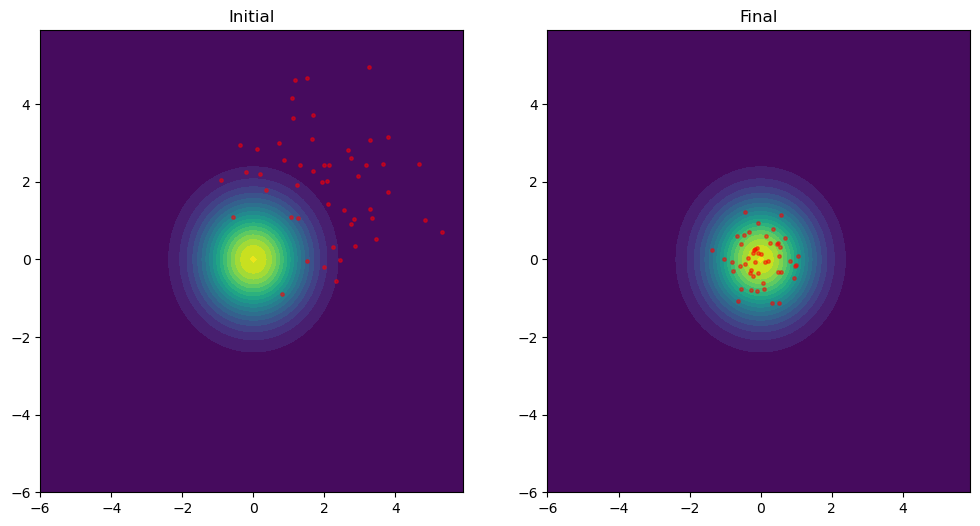

In [5]:
## SVGD
Kernel = RBF
if args.method in ["SVGD", "all"]:
    print("Running SVGD")
    # sample from variational density
    x = x_init.clone().to(device)
    kernel = Kernel(method="med_heuristic")
    svgd = SVGD(distribution, kernel, optim.Adam([x], lr=lr), device=device)
   
    svgd.fit(x, epochs, verbose=True, save_every=save_every)
    

    # plot particles
    fig_svgd = plot_particles(
        x_init.detach(), 
        x.detach(), 
        distribution, 
        d=6.0, 
        step=0.1, 
        concat=means[2:]
    )

tensor(2.0958, device='cuda:0')
tensor([[ 3.0243e-01, -2.0052e-03, -4.6953e-04, -2.7119e-03,  2.6428e-03,
         -6.7554e-04,  1.1521e-04, -5.8981e-04,  4.2101e-04],
        [-2.0052e-03,  3.0461e-01, -1.7522e-03,  2.8213e-03, -4.5008e-04,
          1.5597e-03,  1.8954e-04,  1.6362e-03,  1.5615e-03],
        [-4.6953e-04, -1.7522e-03,  2.9577e-01,  2.8461e-03,  1.3269e-03,
          5.8264e-04, -2.5602e-03, -3.0923e-04, -1.0410e-03],
        [-2.7119e-03,  2.8213e-03,  2.8461e-03,  2.9960e-01,  4.9211e-04,
          3.0570e-03,  2.1961e-04, -5.1522e-04,  1.1690e-03],
        [ 2.6428e-03, -4.5008e-04,  1.3269e-03,  4.9211e-04,  3.0064e-01,
         -4.4346e-03,  1.2516e-03,  8.3240e-04, -4.9867e-04],
        [-6.7554e-04,  1.5597e-03,  5.8264e-04,  3.0570e-03, -4.4346e-03,
          3.0106e-01, -4.5306e-04,  1.5895e-03,  3.4017e-04],
        [ 1.1521e-04,  1.8954e-04, -2.5602e-03,  2.1961e-04,  1.2516e-03,
         -4.5306e-04,  3.0194e-01,  8.3113e-04, -2.2165e-03],
        [-5.8981

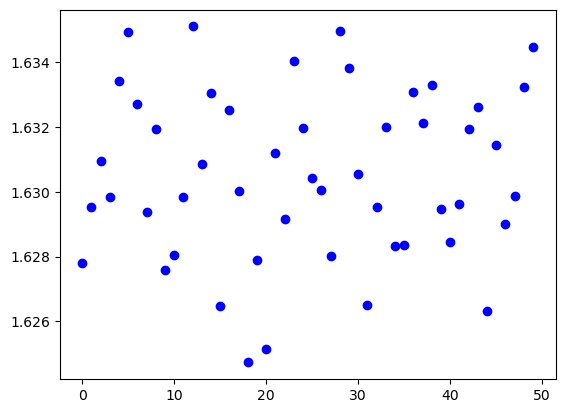

In [6]:
theta  = x
index_svgd = []
samn_svgd = []
for i in range(theta.shape[0]):
    samn_svgd.append(torch.linalg.norm(theta[i,:].cpu()).item())
    index_svgd.append(i)

import matplotlib.pyplot as plt
plt.scatter(index_svgd, samn_svgd, c='blue')
cov_svgd = torch.cov(theta.T)
print(torch.linalg.norm(cov - cov_svgd))
print(cov_svgd)
print(cov - cov_svgd)